# Source
- https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
- https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd
- https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
cd "/content/drive/My Drive/Colab Notebooks/Long_text_Sentiment_BERT"

/content/drive/My Drive/Colab Notebooks/Long_text_Sentiment_BERT


In [204]:
!pip install -qq transformers

In [205]:
!pip install watermark

In [206]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.7.1+cu101
transformers: 4.3.3



In [208]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [209]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [210]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Get the dataset

In [211]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/drive/My Drive/Colab Notebooks/Long_text_Sentiment_BERT/apps.csv
100% 134k/134k [00:00<00:00, 4.30MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/drive/My Drive/Colab Notebooks/Long_text_Sentiment_BERT/reviews.csv
7.17MB [00:00, 63.1MB/s]


# Load the Google Play app reviews dataset
- they have a score from 1 (very negative review) to 5 (very positive review)

In [212]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [160]:
df.score.unique()

array([1, 2, 3, 4, 5])

In [161]:
df.shape

(15746, 11)

In [162]:
df[df.score==5].head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
1000,Fiona Cuff,https://lh3.googleusercontent.com/-EiCakytOHwA...,Update: Thank you for the info! It does what I...,5,117,4.17.0.2,2020-03-12 11:14:40,The date categories filter tasks according to ...,2020-03-10 04:21:05,most_relevant,com.anydo
1001,Brad Black,https://lh3.googleusercontent.com/a-/AOh14GiHs...,Great App! I'm a heavy hitter when it comes to...,5,25,4.16.4.6,2020-01-28 19:21:45,NaN,NaN,most_relevant,com.anydo
1002,Goughy,https://lh3.googleusercontent.com/a-/AOh14Giwz...,"Since Microsoft scrapped ""Wunderlist"" for ""Mic...",5,18,4.17.0.2,2020-03-09 10:12:57,We love hearing Any.do was the solution you we...,2020-03-10 04:28:00,most_relevant,com.anydo
1003,Vladimir Tamindžija,https://lh3.googleusercontent.com/a-/AOh14GgEB...,This is the best productivity app I have ever ...,5,92,4.16.6.2,2020-03-02 21:24:25,NaN,NaN,most_relevant,com.anydo
1004,Eva Gillespie-Larsen,https://lh3.googleusercontent.com/a-/AOh14Gir3...,I'm kind of a geek....I like planners. I used ...,5,73,4.16.6.2,2020-02-26 16:53:34,NaN,NaN,most_relevant,com.anydo


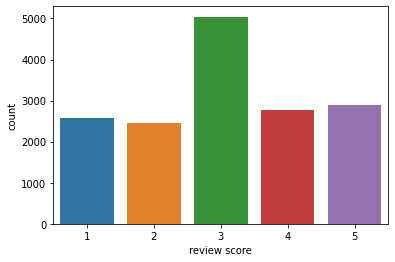

In [80]:
sns.countplot(x=df.score)
plt.xlabel('review score');

## Convert score 1-5 to sentiment 1-3 with class names

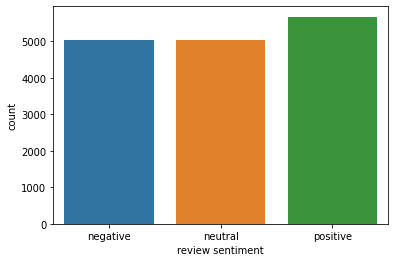

In [213]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2  # scores 4 to 5

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

- shorten long text

In [253]:
def get_split(text1):
  l_total = []
  l_partial = []

  if len(text1.split()) // 150 > 0:
    n = len(text1.split()) // 150
  else:
    n=1

  for w in range(n):
    if w==0:
      l_partial = text1.split()[:200]
      l_total.append(' '.join(l_partial))
    else:
      l_partial = text1.split()[w*150 : w*150 + 200]
      l_total.append(' '.join(l_partial))

  return l_total

df['shortened_content']=df.content.apply(get_split)

# Tokenize reviews

In [215]:
def defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME):
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    return tokenizer

In [216]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

In [217]:
sample_txt='Personal Health Record (Extract)\nCreated on October 24, 2019\nPatient\nSteven Fuerst\nBirthdate\nDecember 10, 1979\nRace\nInformation not\navailable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Personal Health Record (Extract)
Created on October 24, 2019
Patient
Steven Fuerst
Birthdate
December 10, 1979
Race
Information not
available
   Tokens: ['Personal', 'Health', 'Record', '(', 'Extra', '##ct', ')', 'Created', 'on', 'October', '24', ',', '2019', 'Pat', '##ient', 'Steven', 'Fu', '##ers', '##t', 'Birth', '##date', 'December', '10', ',', '1979', 'Race', 'Information', 'not', 'available']
Token IDs: [13907, 3225, 7992, 113, 18684, 5822, 114, 25423, 1113, 1357, 1572, 117, 10351, 7195, 9080, 6536, 14763, 1468, 1204, 20729, 9216, 1382, 1275, 117, 2333, 6398, 4219, 1136, 1907]


## Special tokens

In [169]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


- tokenize

In [218]:
encoding = tokenizer.encode_plus(
                      sample_txt,
                      max_length=64,
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      return_token_type_ids=False,
                      padding='max_length',
                      return_attention_mask=True,
                      return_tensors='pt',  # Return PyTorch tensors
                      truncation=True)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

- the tokens ids are now stored in a Tensor and padded to a length of max_length
- special tokens have been added : CLS at the start of sentence, SEP before padding

In [219]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

64


tensor([  101, 13907,  3225,  7992,   113, 18684,  5822,   114, 25423,  1113,
         1357,  1572,   117, 10351,  7195,  9080,  6536, 14763,  1468,  1204,
        20729,  9216,  1382,  1275,   117,  2333,  6398,  4219,  1136,  1907,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

- attention mask is of same length with the padded zone marked with 0s

In [220]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

64


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [173]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Personal',
 'Health',
 'Record',
 '(',
 'Extra',
 '##ct',
 ')',
 'Created',
 'on',
 'October',
 '24',
 ',',
 '2019',
 'Pat',
 '##ient',
 'Steven',
 'Fu',
 '##ers',
 '##t',
 'Birth',
 '##date',
 'December',
 '10',
 ',',
 '1979',
 'Race',
 'Information',
 'not',
 'available',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [221]:
class GPReviewDataset(Dataset):
  
  def __init__(self, docs, targets, tokenizer, max_len):
    self.docs = docs
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.docs)
  
  def __getitem__(self, item):
    doc = str(self.docs[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
                    doc,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    padding='max_length',
                    return_attention_mask=True,
                    return_tensors='pt',
                    truncation=True)

    return {
            'doc_text': doc,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [254]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    
    ds = GPReviewDataset(
        docs=df.shortened_content.to_numpy(),
        #docs=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
        )

In [255]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [256]:
MAX_LEN = 128
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [257]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['doc_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [258]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [259]:
 dect = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
 last_hidden_state, pooled_output = dect['last_hidden_state'], dect['pooler_output']

In [260]:
print(last_hidden_state.shape)
print(bert_model.config.hidden_size)
print(pooled_output.shape)

torch.Size([1, 64, 768])
768
torch.Size([1, 768])


In [261]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = outputs["pooler_output"]
        output = self.drop(pooled_output)
        return self.out(output)

In [262]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [263]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [264]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
    ):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [265]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

loss_fn = nn.CrossEntropyLoss().to(device)

In [267]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7322469126626546 accuracy 0.6698186437089831
Val   loss 0.5978097113966941 accuracy 0.7674714104193139

Epoch 2/10
----------
Train loss 0.4325433523766276 accuracy 0.8386846376402513
Val   loss 0.5110899098217487 accuracy 0.829733163913596

Epoch 3/10
----------
Train loss 0.24683464523856832 accuracy 0.9187777856185168
Val   loss 0.5882115899398923 accuracy 0.8589580686149937

Epoch 4/10
----------
Train loss 0.16667827797667847 accuracy 0.9508150448098229
Val   loss 0.691361335394904 accuracy 0.8691232528589581

Epoch 5/10
----------
Train loss 0.12687493951087997 accuracy 0.9661280079034649
Val   loss 0.790417731651105 accuracy 0.8742058449809403

Epoch 6/10
----------
Train loss 0.0937706532034183 accuracy 0.9752311057794086
Val   loss 0.8231002280546817 accuracy 0.8742058449809403

Epoch 7/10
----------
Train loss 0.07264953364785519 accuracy 0.9793945381412744
Val   loss 0.8782042180531425 accuracy 0.8716645489199493

Epoch 8/10
----------
Trai

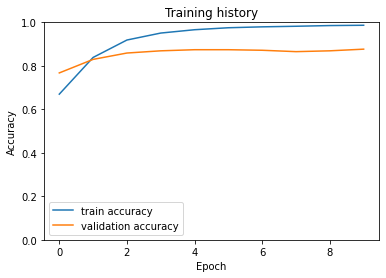

In [268]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [269]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [270]:
test_acc, _ = eval_model(
          model,
          test_data_loader,
          loss_fn,
          device,
          len(df_test)
        )
print('\nTest Accuracy:\n')
print(test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
    )

print(classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy:

0.883248730964467
              precision    recall  f1-score   support

    negative       0.91      0.86      0.88       245
     neutral       0.83      0.87      0.85       254
    positive       0.91      0.91      0.91       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



In [272]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["doc_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [273]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [274]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.91      0.86      0.88       245
     neutral       0.83      0.87      0.85       254
    positive       0.91      0.91      0.91       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



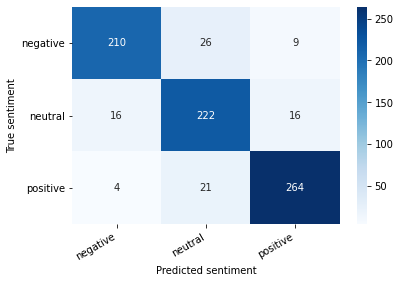

In [275]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [276]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

["I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars."]

True sentiment: neutral


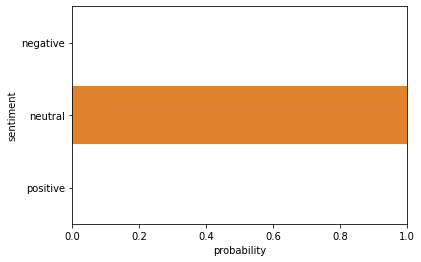

In [277]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [278]:
review_text = "I love completing my todos! Best app ever!!!"

In [279]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [280]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


In [290]:
review_text = "the food was pretty good but I will not bother coming back"

In [291]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [292]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: the food was pretty good but I will not bother coming back
Sentiment  : neutral
